In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch import nn
from torch.utils.data import DataLoader

In [2]:
plt.rcParams['figure.figsize'] = (8, 6)
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device}")

Using cpu


In [3]:
customers = pd.read_csv('./data/spending.csv')
customers.sample(10)

,Email,Address,Avatar,Avg. Session Length,Time on App,Time on Website,Length of Membership,Yearly Amount Spent
426,rwilliams@trujillo.biz,"54560 Thompson Creek Apt. 029\nNew Brianville,...",BlanchedAlmond,31.425227,13.271475,37.239847,4.022103,530.766719
388,judithsmith@jimenez.biz,"186 Anthony Route\nGordonview, AS 78120-4633",DarkOrange,33.590486,10.942070,36.170494,2.783963,407.542168
160,blevinseric@stephens.com,"PSC 3676, Box 1549\nAPO AE 26130-7683",Orange,32.838100,12.364342,38.039109,3.309182,468.913501
166,allison80@carson-hansen.com,"04311 Oconnor Park Apt. 415\nKelleystad, ND 63...",ForestGreen,33.630801,12.039648,38.924087,2.873008,497.811930
115,whess@hotmail.com,"29282 Alexander Street\nSouth Andrewmouth, MS ...",Tomato,33.235607,11.223369,37.692301,2.594190,413.371783
116,josesims@hunter.com,"8830 Debra Loaf Apt. 341\nDrakeville, ME 22340",SlateBlue,33.925795,12.011022,36.701052,2.753424,479.231093
74,haydenrebecca@gmail.com,"10022 Wilson Orchard Suite 107\nHarrisstad, MH...",MintCream,33.879745,13.587806,38.260353,3.258113,578.241605
134,jill33@allen.com,"459 Amy Burg\nLake Travis, OR 53314",DarkCyan,33.540977,11.851891,37.424548,1.767731,407.804031
336,jeffery48@mcguire.com,"52326 Townsend Centers\nLake Williamburgh, NJ ...",LightCyan,32.302553,11.979061,38.269061,3.532862,478.600916
491,leonardhancock@hotmail.com,64147 Alexander Station Apt. 474\nEast Jasonvi...,SeaShell,34.343922,11.693058,36.812934,3.447093,510.501478


In [4]:
customers = customers.drop(columns=['Email', 'Address', 'Avatar'])

In [5]:
X = customers.drop(columns='Yearly Amount Spent')
y = customers['Yearly Amount Spent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Feature scaling

* Features haben unterschiedliche Wertebereiche
  population: [0, 35000] vs median_income: [0, 15]
![scaling](./assets/scaling.png)
* Feature scaling bringt alle Features zusammen
* *Normalization* x -> [0, 1] $$x' = \frac{x-x_{min}}{x_{max} - x_{min}}$$
* *Standardization* x -> Standardnormalverteilt  $$x' = \frac{x-\mu}{\sigma}$$

Wichtig bei
* Algorithmen, die mit Distanzen arbeiten (SVM, ...)
* ANNs

In [6]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Biologisches Neuron

![Biological neuron](./assets/neuron.webp)

* Inputs in Form von elektrischen Signalen
* Input kommt über Dendriten
* Falls Summe der Inputs Schwelle(*Aktivierungspotential*) überschreitet, wird Signal weitergeleitet

## Künstliches Neuron(*Perceptron*)

![Artificial neuron](./assets/artificial-neuron.jpg)

* Inputs (x_i) sind die Features einer Observation
* Die Inputs werden verschieden gewichtet ($w_i$)
* Lernen => Gewichte adaptieren
* $$ output = f(\sum_i x_iw_i) = f(\vec{x}\vec{w}^T) $$

## Network
![ann-architecture](./assets/ann-architecture.png)

In [7]:
class SpendingDataset(torch.utils.data.Dataset):

    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).to(device)
        self.y = torch.tensor(y.to_numpy(), dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        data = self.X[index]
        spending = self.y[index].unsqueeze(0)  # extra Dimension
        return data, spending

In [8]:
SpendingDataset(X_train, y_train)[:3]

(tensor([[ 0.8190, -0.0218, -2.4676,  1.8669],
         [ 0.8743, -0.0376, -0.2881, -0.8006],
         [ 1.5106,  0.1213,  2.0932,  0.0850]]),
 tensor([[637.1025, 479.2311, 549.8606]]))

In [9]:
X_train.shape

(350, 4)

In [10]:
class NeuralNetwork(nn.Module):
    def __init__(self, neurons):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(X_train.shape[1], neurons),
            nn.ReLU(),
            nn.Linear(neurons, neurons),
            nn.ReLU(),
            nn.Linear(neurons, 1),
        )

    def forward(self, x):
        spending = self.linear_relu_stack(x)
        return spending


model = NeuralNetwork(neurons=4).to(device)
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=4, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=4, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=1, bias=True)
  )
)


In [11]:
data = SpendingDataset(X_train, y_train)[:3][0]
predictions = model(data)
print(f"Predicted spending: {predictions}")

Predicted spending: tensor([[-0.1685],
        [-0.1161],
        [-0.1287]], grad_fn=<AddmmBackward0>)


In [12]:
batch_size = 64
training_data = SpendingDataset(X_train, y_train)
test_data = SpendingDataset(X_test, y_test)
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

[Training loop](http://experiments.mostafa.io/public/ffbpann/)

In [13]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

X, y = training_data[:64]
pred = model(X)
loss = loss_fn(pred, y.transpose(0, 1))

# Backpropagation
loss.backward() # calculate gradients
optimizer.step() # update weights
optimizer.zero_grad() # gradients = 0
print(loss.item())

261366.6875


## Gradient Descent

![gd](./assets/gradient-descent.png)
![](./assets/opt1.gif)
* Minimum der Loss function finden

In [14]:
def train_loop(dataloader, model, loss_fn, optimizer):
    num_batches = len(dataloader)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    running_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        running_loss += loss.item()

        # Backpropagation
        loss.backward() # calculate gradients
        optimizer.step() # update weights
        optimizer.zero_grad() # gradients = 0

    return running_loss / num_batches


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    num_batches = len(dataloader)
    test_loss = 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    return test_loss

In [15]:
#for t in epochs: # epochs = 1x alles gesehen
#    train_loop()
#    test_loop()

Epoch 0
-------------------------------
Training_loss: 258818.37760416666
Test_loss: 244483.75520833334

Epoch 10
-------------------------------
Training_loss: 245555.08854166666
Test_loss: 230244.65625

Epoch 20
-------------------------------
Training_loss: 152117.74869791666
Test_loss: 133677.39583333334

Epoch 30
-------------------------------
Training_loss: 22973.174153645832
Test_loss: 18343.532552083332

Epoch 40
-------------------------------
Training_loss: 7307.4345703125
Test_loss: 6708.192057291667

Epoch 50
-------------------------------
Training_loss: 5365.248046875
Test_loss: 5343.872233072917



<Axes: >

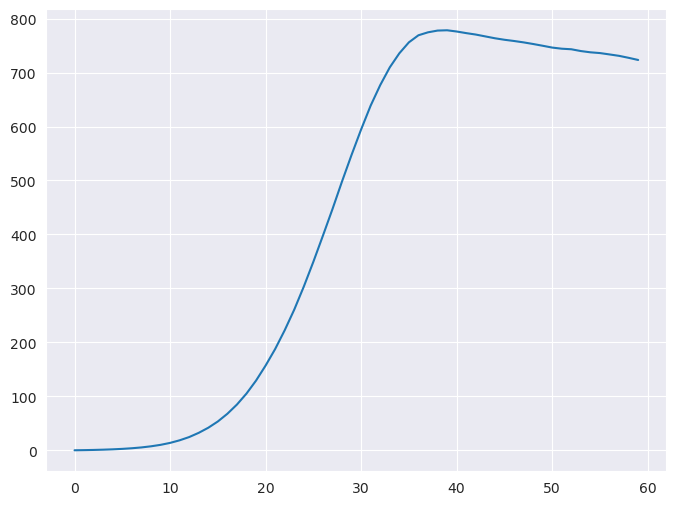

In [16]:
model = NeuralNetwork(neurons=4).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
history = {'training_loss': [], 'test_loss': [], 'predictions': []}

for t in range(60):
    training_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    history['training_loss'].append(training_loss)
    test_loss = test_loop(test_dataloader, model, loss_fn)
    history['test_loss'].append(test_loss)
    prediction = model(torch.from_numpy(X_train[0]).to(torch.float32).to(device)).item()
    history['predictions'].append(prediction)
    if t % 10 == 0:
        print(f"Epoch {t}\n-------------------------------")
        print(f'Training_loss: {training_loss}')
        print(f'Test_loss: {test_loss}')
        print()

sns.lineplot(data=history.pop('predictions'))

<Axes: >

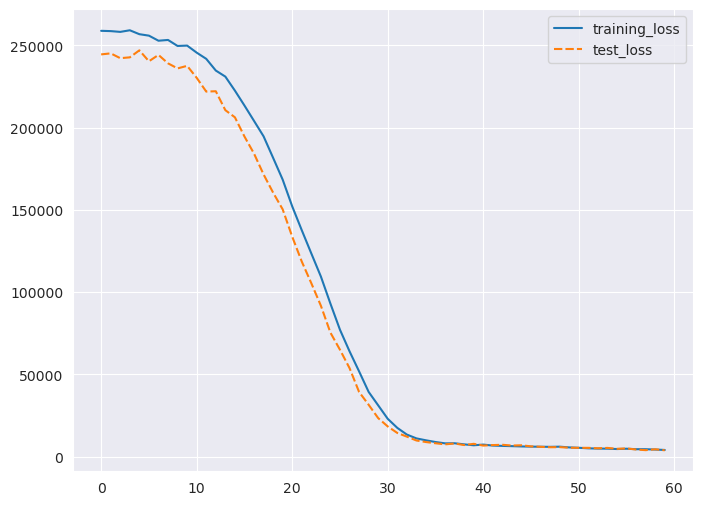

In [17]:
sns.lineplot(data=history)

In [18]:
last_epochs = {}
for k, v in history.items():
   last_epochs[k] = v[1:10]

<Axes: >

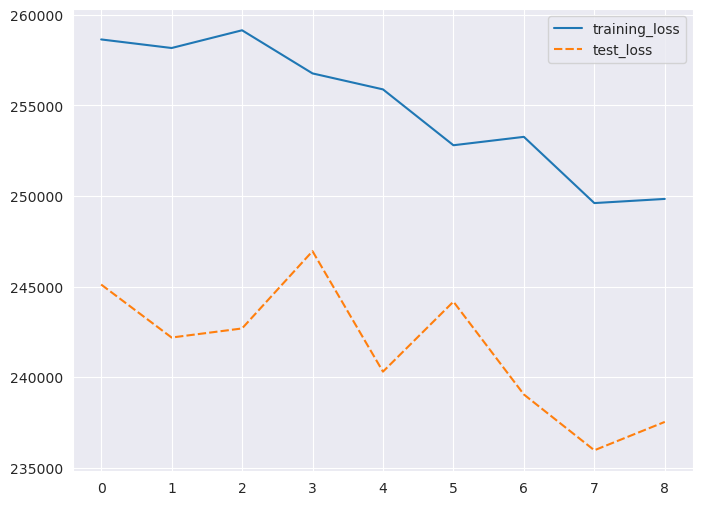

In [19]:
sns.lineplot(data=last_epochs)